# Rotten Tomatoes Sentiment Analysis
David Zhu | Spring 2017 | Machine Learning Independent Study

The goal of this project is to explore different machine learning techniques on sentiment analysis. Text sentiment analysis is an interesting ML topic since word data is sparse relative to images. The meanings and grammar of language may carry a lot of meaning, but letters themselves are not as data-rich as pixels.

We will be looking at a [Rotten Tomatoes movie review dataset provided by Kaggle](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews).

## Preprocessing

First, let's load in our dependencies.

In [1]:
# Imports
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords # Import the stop word list

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [2]:
# Configure matplotlib correctly
%matplotlib inline
sns.set() # Prettify all matplotlib plots

In [3]:
# If NLTK is not loaded, download NLTK datasets
downloaded = True
if not downloaded:
    nltk.download() 

Now, let's use pandas to load in our datasets and get some basic information on its structure.

In [4]:
# Load our training and test datasets
train_df = pd.read_csv('data/train.tsv', delimiter = '\t', encoding = 'utf-8')
test_df = pd.read_csv('data/test.tsv', delimiter = '\t', encoding = 'utf-8')
sample_submission_df = pd.read_csv('data/sampleSubmission.csv', delimiter = ',', encoding = 'utf-8')

# Get some basic info
print("Train data dimensions: " + str(train_df.shape))
print("Train columns: " + str(train_df.columns.values))
print("Test data dimensions: " + str(test_df.shape))
print("Test columns: " + str(test_df.columns.values))
print("Sample submission data dimensions: " + str(sample_submission_df.shape))
print("Sample submission columns: " + str(sample_submission_df.columns.values))

Train data dimensions: (156060, 4)
Train columns: ['PhraseId' 'SentenceId' 'Phrase' 'Sentiment']
Test data dimensions: (66292, 3)
Test columns: ['PhraseId' 'SentenceId' 'Phrase']
Sample submission data dimensions: (66292, 2)
Sample submission columns: ['PhraseId' 'Sentiment']


To extract out the most useful info from our text, let's remove any filler words with little added meaning. These words are called stopwords, and NLTK provides us with a corpus which we can use to clean our data.

In [43]:
stops = set(stopwords.words("english")) 

def clean_df(df):
    df['phrase_cleaned'] = df['Phrase'].str.lower() # Lowercases the strings
    df['phrase_cleaned'] = df['phrase_cleaned'].str.split().apply(lambda x: " ".join([item for item in x if item not in stops]))
    
clean_df(train_df)
clean_df(test_df)

print("Original: ", train_df['Phrase'][0])
print("Cleaned: ", train_df['phrase_cleaned'][0])

Original:  A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
Cleaned:  series escapades demonstrating adage good goose also good gander , occasionally amuses none amounts much story .


## Feature exploration and extraction

One of the challenges with text is that a computer cannot directly understand words like humans do. We must convert text into a form that a computer can input. There are several ways that we could do this, for instance by looking at the quantitative aspects of a section of text. Following are some ways we can extract quantifiable meaning out of text.

### Sentiment distribution

Let's first look at the distribution of our dataset. We can map the frequency of each sentiment and compare.

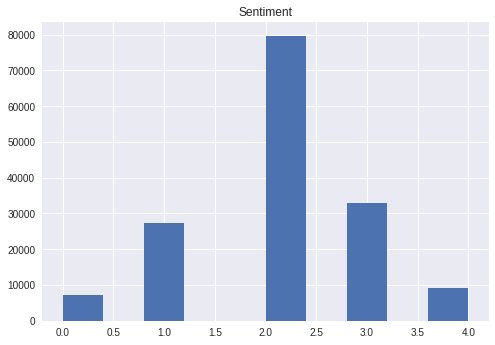

In [6]:
# Visualize the distribution of our dataset in sentiment.
train_df.hist(column = "Sentiment")
plt.show()

Based on this graph, we can see that most of our dataset skews towards a sentiment of 2, which is neutral. This is something that we should take into consideration as we train our models for prediction. For instance, we may create classifiers that are biased to guess 2 based on the input. Therefore, we should also evaluate the precision and recall  (and the combined F1 score) of our predictions to get a better grasp of the model quality.

### Phrase length

Something basic that we can evaluate is the length of the text. Different lengths of text may correlate to the sentiment of a text.

In [7]:
# Create a new column with the word count evaluated
train_df['phrase_length'] = train_df['phrase_cleaned'].str.len()

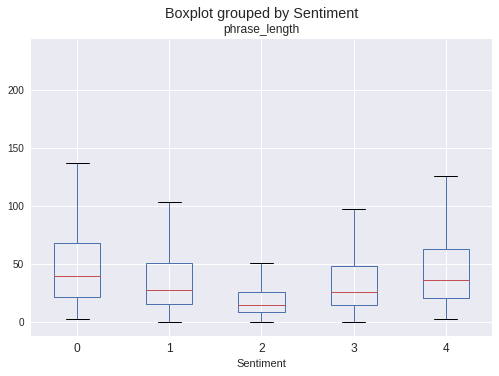

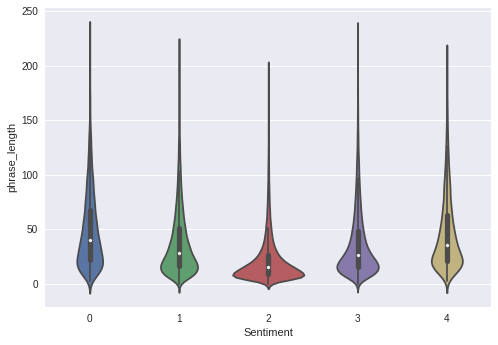

In [8]:
# Visualize
train_df.boxplot(column='phrase_length', by='Sentiment')
plt.show()

sns.violinplot(x="Sentiment", y="phrase_length", data=train_df)
plt.show()

Visualizing the phrase length along a sentiment reveals that neutral sentiment phrases are typically shorter and low-variance. This feature may help classifiers better identify opinionated vs neutral sentiment.

### Vector representations

Rather than having just one dimension features, one way we can capture more information is to represent string features in vectors. The first technique that we can use is Bag-of-words.

#### Bag-of-words

Bag-of-words is a method to represent words based on the frequency of how many times words appear. First, we would like to traverse through our dataset and build a vocabulary of all the words used. Then, we tally up how many times each word appears. We take the most popular words of the dataset and treat it as a vector with values as their counts. Then, we can take each *individual* phrase and convert it into a vector based on the appearances of any of the chosen vocabulary. Using this vector form, we can now train classifiers to make decisions.

For this reason, it is handy for us to remove stop words as to not clutter up our vocabulary with words that do not generate signal on sentiment.

Following, we use Sklearn's count vectorizer to create our vocabulary and convert phrases into bag-of-words vectors.

In [9]:
def get_count_vectorizer(max_vocab):
    return CountVectorizer(
        analyzer = "word", \
        tokenizer = None, \
        preprocessor = None, \
        stop_words = None, \
        max_features = max_vocab)

# Let's try using the top 5000 words first.
count_vectorizer = get_count_vectorizer(5000)
phrase_bow_vectors = count_vectorizer.fit_transform(train_df['phrase_cleaned']).toarray()
print(phrase_bow_vectors.shape)

(156060, 5000)


The CountVectorizer converted our phrases to lengh-5000 vectors. Let's see which words are used in our vocabulary.

In [10]:
def get_vocab_and_magnitude(vectorizer, vectors):
    """
    Returns the vocabulary and its magnitude from a given vectorizer 
    """
    # Take a look at the words in the vocabulary
    vocab = np.array(vectorizer.get_feature_names())

    # Sum up the counts of each vocabulary word
    magnitude = np.sum(vectors, axis=0)

    sort_idxs = magnitude.argsort()[::-1]
    magnitude = magnitude[sort_idxs]
    vocab = vocab[sort_idxs]
    
    return vocab, magnitude


def print_zip(list_1, list_2, count):
    for a, b in list(zip(list_1, list_2))[0:count]:
        print(a, b)

        
bow_vocab, bow_magnitude = get_vocab_and_magnitude(count_vectorizer, phrase_bow_vectors)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
print_zip(bow_magnitude, bow_vocab, 20)

6733 film
6241 movie
3784 one
3190 like
2539 story
2438 rrb
2261 good
2098 lrb
1919 time
1882 characters
1872 much
1813 comedy
1718 life
1624 even
1605 little
1583 funny
1535 well
1529 way
1414 make
1345 movies


#### TF-IDF

Anyone way of representing text as a vector is by using TF-IDF. TF-IDF stands for term frequency–inverse document frequency, and it is a more advanced method compared to bag-of-words because it also takes into consideration how many times a word appears in multiple documents.

For example, if a very popular word appears in *all* of our phrases, then that word would lose sentiment predictive power. TF-IDF penaltizes this effect, so we can build a vocabulary that is more aligned with a specific type of sentiment, which our classifiers can later pick up.

Using Sklearn, we make this conversion.

In [11]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=200, \
    max_df = 6000, \
    sublinear_tf=True, \
    use_idf=True)
phrase_tfidf_vectors = tfidf_vectorizer.fit_transform(train_df['phrase_cleaned']).toarray()
print(phrase_tfidf_vectors.shape)

(156060, 491)


We can see that, rather than a 5000-length vector, our vector length is now only 491. This is actually a good thing, as a denser vector can be less computationally expensive to train while retaining relevant data.

In [12]:
tfidf_vocab, tfidf_magnitude = get_vocab_and_magnitude(tfidf_vectorizer, phrase_tfidf_vectors)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
print_zip(tfidf_magnitude, tfidf_vocab, 20)

1847.05674869 one
1587.34322506 like
1381.94895977 story
1223.50244332 good
1189.91375002 rrb
1083.40943755 characters
1050.45164456 comedy
1038.04017392 much
1032.53751111 time
1000.24809845 life
956.268631535 lrb
947.882748343 funny
943.441593633 little
895.707026178 well
889.274696866 way
880.50117125 even
805.45053268 love
802.245810967 director
782.578188478 work
782.380853253 bad


Comparing to the above, TF-IDF seems to have a more opiniated vocabulary, which should help improve training accuracy. Let's also compare the vocabulary frequency between bag-of-words and tf-idf.

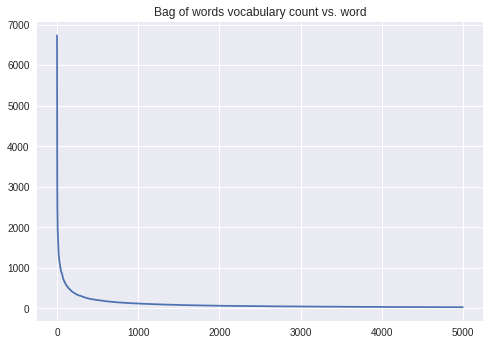

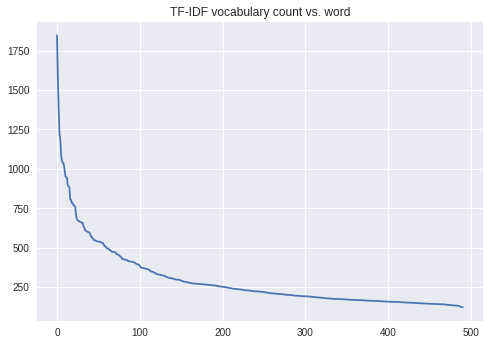

In [13]:
plt.plot(bow_magnitude)
plt.title("Bag of words vocabulary count vs. word")
plt.show()

plt.plot(tfidf_magnitude)
plt.title("TF-IDF vocabulary count vs. word")
plt.show()

TF-IDF's density is higher relative to BOW. We would expect to see more zeros in a BOW vector than TF-IDF.

## Modeling

We are ready to take our extracted features and attempt to train some models. The following are a variety of models that can input features and output a sentiment prediction. We each model, we can evaluate its performance to submit to Kaggle.

### Naive model

First, let's use a dummy benchmark model. This model will predict neural `2` for all inputs. Based on what we've seen about the data distribution, we expect about half of our predictions to be accurate.

In [14]:
# Define a super basic model that only returns neutral sentiment
class NaiveModel():
    def predict(self, phrases):
        return np.full((len(phrases), 1), 2)
    
    
# Use the naive model to run a predication on our cross validation dataset
naive_model = NaiveModel()
predictions = naive_model.predict(train_df['Phrase'])
    
    
def print_metrics(predictions, actual):
    """
    Prints out some basic information about the performance of the model predictions
    """
    print("Accuracy: " + str(metrics.accuracy_score(actual, predictions)))
    print(metrics.classification_report(actual, predictions))
    

print_metrics(predictions, train_df['Sentiment'])

Accuracy: 0.50994489299
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      7072
          1       0.00      0.00      0.00     27273
          2       0.51      1.00      0.68     79582
          3       0.00      0.00      0.00     32927
          4       0.00      0.00      0.00      9206

avg / total       0.26      0.51      0.34    156060



/home/hdavidzhu/miniconda3/envs/ml_is/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
def export_to_kaggle(predictions, name):
    """
    Packages up testing results for Kaggle upload
    """
    test_df['Sentiment'] = predictions
    submission_df = test_df[['PhraseId', 'Sentiment']].copy()
    submission_df.to_csv(path_or_buf='data/submission_' + name + '.csv', index=False)


export_to_kaggle(naive_model.predict(test_df['Phrase']), 'naive_model_01')

The resulting accuracy is **0.51789**. Although we were able to get ~50% accuracy, our precision, recall, and F1 score are terrible. Precision represents the accuracy of our predictions for a selected sentiment, and recall represents how many of our selected sentiment were accurate. The F1 score is derived from precision and recall, and it helps us quantify having good 'accuracy' without lose the balance between precision and recall.

Looking at the table above, our precision and recall were zeros for any non-2 sentiment phrases. That means, for instance, that non of the 1-sentiment phrases were guessed correctly, and non of the correct guesses were 1's.  

### Support Vector Machines

Support vector machines are classifers that seperates data groups by a line (or hyperplane). It does so by trying to positioning itself equidistantly between two classes. Let's try applying our features to this model to predict sentiment.

To let our SVM determine distance, let's use the default RBF kernel (radial basis function). 

In [16]:
def get_train_test_splits(features, test_size=0.1):
    return train_test_split(
        features,
        train_df['Sentiment'],
        test_size = test_size, 
        random_state = 37)

In [17]:
%%script false

# Split our vector data for training and validation
X_train, X_val, y_train, y_val = get_train_test_splits(phrase_bow_vectors, 0.1)
X_train, X_val, y_train, y_val = get_train_test_splits(phrase_tfidf_vectors, 0.1)

# Create and train our SVM
svm_classifier = SVC(verbose=True)
svm_classifier.fit(X_train, y_train)

Unfortuntately, running on 140454 data samples is too resource intensive for SVC, and our system hangs. According to sklearn's SVC documentation, "the fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples."

Let's try again but with much less training data.

In [29]:
# We'll only use 5% of our data for training, which is 7803 points.
X_train, X_val, y_train, y_val = get_train_test_splits(phrase_tfidf_vectors, 0.95)

In [22]:
%%script false
# Create and train our SVM
svm_classifier = SVC(verbose=True)
svm_classifier.fit(X_train, y_train)
joblib.dump(svm_classifier, 'svm_v3.pkl')

In [23]:
svm_classifier = joblib.load('svm_v3.pkl') 

In [24]:
predictions = svm_classifier.predict(X_val[0:1000])
print_metrics(predictions, y_val[0:1000])

Accuracy: 0.496
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        39
          1       0.00      0.00      0.00       198
          2       0.50      1.00      0.66       496
          3       0.00      0.00      0.00       211
          4       0.00      0.00      0.00        56

avg / total       0.25      0.50      0.33      1000



/home/hdavidzhu/miniconda3/envs/ml_is/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


That's not promising. It seems that our SVM classifier also only predicts 2s.

Let's try using the phrase length feature to determine sentiment.

In [33]:
X_train, X_val, y_train, y_val = get_train_test_splits(train_df['phrase_length'], 0.8)

In [ ]:
svm_classifier = SVC(verbose=True)

# We need to use np.newaxis to conform to the fit()'s expected syntax
svm_classifier.fit(X_train[:, np.newaxis], y_train)

joblib.dump(svm_classifier, 'svm_v4_length.pkl')

In [37]:
svm_classifier = joblib.load('svm_v4_length.pkl')
predictions = svm_classifier.predict(X_val[:, np.newaxis][0:5000])
print_metrics(predictions, y_val[0:5000])

Accuracy: 0.5038
             precision    recall  f1-score   support

          0       0.33      0.00      0.01       220
          1       0.23      0.03      0.05       904
          2       0.53      0.95      0.68      2528
          3       0.24      0.09      0.13      1058
          4       0.00      0.00      0.00       290

avg / total       0.38      0.50      0.38      5000



Using a simpler feature for our SVM improved performance, as some non-2 sentiment predictions were made. Longer training may help with the other models using bag-of-words and tf-idf.

### Naive Bayes

Naive bayes is a popular classification algorithm used in natural language processing, typically as a baseline. Naive bayes uses the Bayes theorem and assumes strong independence between features. This means that, by disregarding probability calculations among features, the probability of of a given result is simply the normalized multiplication of all feature probabilities. One benefit of this is that the probability is linearly dependent on how many features we use, and training becomes much faster. 

In [46]:
from sklearn.naive_bayes import MultinomialNB

X_train, X_val, y_train, y_val = get_train_test_splits(phrase_tfidf_vectors, 0.1)

naive_bayes_clf = MultinomialNB()
naive_bayes_clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [47]:
predictions = naive_bayes_clf.predict(X_val)
print_metrics(predictions, y_val)

Accuracy: 0.535691400743
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       712
          1       0.48      0.05      0.08      2715
          2       0.54      0.97      0.69      7963
          3       0.50      0.15      0.23      3346
          4       0.67      0.00      0.00       870

avg / total       0.50      0.54      0.42     15606



/home/hdavidzhu/miniconda3/envs/ml_is/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
test_data_features = tfidf_vectorizer.transform(test_df['phrase_cleaned']).toarray()
print(test_data_features.shape)

export_to_kaggle(naive_bayes_clf.predict(test_data_features), 'naive_bayes_01')

(66292, 491)


The resulting Kaggle accuracy is **0.53540**.

Let's also try the bag-of-words to see how well it performs.

In [49]:
X_train, X_val, y_train, y_val = get_train_test_splits(phrase_bow_vectors, 0.1)

naive_bayes_clf = MultinomialNB()
naive_bayes_clf.fit(X_train, y_train)
predictions = naive_bayes_clf.predict(X_val)
print_metrics(predictions, y_val)

Accuracy: 0.603549916699
             precision    recall  f1-score   support

          0       0.48      0.26      0.33       712
          1       0.50      0.30      0.38      2715
          2       0.65      0.86      0.74      7963
          3       0.53      0.40      0.45      3346
          4       0.51      0.29      0.37       870

avg / total       0.58      0.60      0.58     15606



Surprisingly, Naive Bayes performed best using bag-of-words vectors! Let's first evaluate on Kaggle to get test result accuracy.

In [50]:
test_data_features = count_vectorizer.transform(test_df['phrase_cleaned']).toarray()
print(test_data_features.shape)

export_to_kaggle(naive_bayes_clf.predict(test_data_features), 'naive_bayes_02')

(66292, 5000)


Kaggle returned **0.59497** in accuracy. I was really surpised that BOW performed much better than TF-IDF. It could be that TF-IDF is more lossy than BOW in capturing sentiment data, and we may want to tune those hyperparameters to get a better fit.

Let's see if reducing the min threshold of our TF-IDF vectorizers would help improve accuracy.

In [52]:
def get_tfid_vectorizer(min_df=200, max_df=6000):
    return TfidfVectorizer(
        min_df=min_df, \
        max_df = max_df, \
        sublinear_tf=True, \
        use_idf=True)

tfidf_vec_2 = get_tfid_vectorizer(min_df=100).fit_transform(train_df['phrase_cleaned']).toarray()
print(tfidf_vec_2.shape)

naive_bayes_clf = MultinomialNB()

X_train, X_val, y_train, y_val = get_train_test_splits(tfidf_vec_2, 0.1)
naive_bayes_clf.fit(X_train, y_train)
predictions = naive_bayes_clf.predict(X_val)
print_metrics(predictions, y_val)

(156060, 1181)
Accuracy: 0.555299243881
             precision    recall  f1-score   support

          0       0.77      0.02      0.05       712
          1       0.50      0.10      0.16      2715
          2       0.56      0.96      0.71      7963
          3       0.53      0.22      0.31      3346
          4       0.58      0.03      0.06       870

avg / total       0.55      0.56      0.46     15606



In [53]:
tfidf_vec_3 = get_tfid_vectorizer(min_df=50).fit_transform(train_df['phrase_cleaned']).toarray()
print(tfidf_vec_3.shape)

X_train, X_val, y_train, y_val = get_train_test_splits(tfidf_vec_3, 0.1)
naive_bayes_clf.fit(X_train, y_train)
predictions = naive_bayes_clf.predict(X_val)
print_metrics(predictions, y_val)

(156060, 2475)
Accuracy: 0.569780853518
             precision    recall  f1-score   support

          0       0.67      0.03      0.06       712
          1       0.50      0.15      0.23      2715
          2       0.58      0.94      0.72      7963
          3       0.54      0.28      0.37      3346
          4       0.59      0.06      0.11       870

avg / total       0.56      0.57      0.49     15606



In [54]:
tfidf_vec_4 = get_tfid_vectorizer(min_df=25).fit_transform(train_df['phrase_cleaned']).toarray()
print(tfidf_vec_4.shape)

X_train, X_val, y_train, y_val = get_train_test_splits(tfidf_vec_4, 0.1)
naive_bayes_clf.fit(X_train, y_train)
predictions = naive_bayes_clf.predict(X_val)
print_metrics(predictions, y_val)

(156060, 4840)
Accuracy: 0.580802255543
             precision    recall  f1-score   support

          0       0.52      0.05      0.09       712
          1       0.51      0.20      0.29      2715
          2       0.59      0.92      0.72      7963
          3       0.54      0.32      0.40      3346
          4       0.65      0.08      0.14       870

avg / total       0.57      0.58      0.52     15606



In [55]:
tfidf_vec_5 = get_tfid_vectorizer(min_df=10).fit_transform(train_df['phrase_cleaned']).toarray()
print(tfidf_vec_5.shape)

X_train, X_val, y_train, y_val = get_train_test_splits(tfidf_vec_5, 0.1)
naive_bayes_clf.fit(X_train, y_train)
predictions = naive_bayes_clf.predict(X_val)
print_metrics(predictions, y_val)

(156060, 10789)
Accuracy: 0.58810713828
             precision    recall  f1-score   support

          0       0.65      0.06      0.11       712
          1       0.51      0.25      0.34      2715
          2       0.61      0.90      0.72      7963
          3       0.53      0.37      0.44      3346
          4       0.56      0.07      0.12       870

avg / total       0.57      0.59      0.53     15606



In [56]:
tfidf_vec_6 = get_tfid_vectorizer(min_df=25, max_df=1.0).fit_transform(train_df['phrase_cleaned']).toarray()
print(tfidf_vec_6.shape)

X_train, X_val, y_train, y_val = get_train_test_splits(tfidf_vec_6, 0.1)
naive_bayes_clf.fit(X_train, y_train)
predictions = naive_bayes_clf.predict(X_val)
print_metrics(predictions, y_val)

(156060, 4842)
Accuracy: 0.580161476355
             precision    recall  f1-score   support

          0       0.52      0.05      0.09       712
          1       0.51      0.20      0.28      2715
          2       0.59      0.92      0.72      7963
          3       0.54      0.32      0.40      3346
          4       0.67      0.08      0.14       870

avg / total       0.57      0.58      0.52     15606



It seems that, even with tuning, our TF-IDF was not able to perform better than BOW using Naive Bayes. My assumption about TF-IDF placing more meaningful weighting on specified words could be wrong when considering sentiment. 

### Random Forest Classifier

Finally, I wanted to try a random forest classifier. A random forest classifier utilizes many different decision trees to make a prediction. Each decision tree is presented with a subset of features and data to consider, so that they may each learn something different about the dataset. When it is time to predict, each decision tree makes its own predictions and cast a vote. Finally, the most popular vote becomes the prediction.

What's great about a random forest is that, because it is an ensemble learning technique, high noise and variance can be essentially filtered out. It is harder to overfit a random forest classifier because each individual decision tree is only considering a subset of features.

Let's build a random forest with 100 trees. We'll use the Bag-of-words vectors for training, since it performed well in our naive bayes classifier.

In [ ]:
forest = RandomForestClassifier(n_estimators = 100, verbose=3, n_jobs=-1) 
forest = forest.fit(phrase_bow_vectors, train_df["Sentiment"])

In [ ]:
# Let's cache this model since it takes a very long time to train.
joblib.dump(forest, 'forest_v2.pkl')

In [44]:
forest = joblib.load('forest_v2.pkl') 

In [45]:
forest_predictions = forest.predict(phrase_bow_vectors)

[Parallel(n_jobs=96)]: Done  11 out of 100 | elapsed:    5.0s remaining:   40.8s
[Parallel(n_jobs=96)]: Done  45 out of 100 | elapsed:    8.5s remaining:   10.4s
[Parallel(n_jobs=96)]: Done  79 out of 100 | elapsed:    9.4s remaining:    2.5s
[Parallel(n_jobs=96)]: Done 100 out of 100 | elapsed:    9.9s finished


In [46]:
print_metrics(forest_predictions, train_df['Sentiment'])

Accuracy: 0.80594643086
             precision    recall  f1-score   support

          0       0.77      0.67      0.72      7072
          1       0.78      0.68      0.73     27273
          2       0.82      0.91      0.86     79582
          3       0.80      0.71      0.75     32927
          4       0.81      0.69      0.74      9206

avg / total       0.80      0.81      0.80    156060



In [47]:
# Preprocessing submission data
clean_df(test_df)

# Use model to predict results
test_data_features = vectorizer.transform(test_df['phrase_cleaned']).toarray()
test_forest_predictions = forest.predict(test_data_features)

[Parallel(n_jobs=96)]: Done  11 out of 100 | elapsed:    2.3s remaining:   18.5s
[Parallel(n_jobs=96)]: Done  45 out of 100 | elapsed:    3.8s remaining:    4.7s
[Parallel(n_jobs=96)]: Done  79 out of 100 | elapsed:    4.1s remaining:    1.1s
[Parallel(n_jobs=96)]: Done 100 out of 100 | elapsed:    4.3s finished


In [52]:
# Save output to csv for submission
export_to_kaggle(test_forest_predictions, 'random_forest_02')

The first time I submitted to Kaggle on `random_forest_01`, we got back `0.43603` as our accuracy. After some debugging, I realized that the method `fit_transform` causes our Vectorizer to re-fit to the new test dataset. By simply using `transform`, we now conform better to what our random forest classifier expects.

`random_forest_02` score **0.58420**. The `0.80594643086` accuracy on our training dataset is caused by us evaluating accuracy on the training dataset. This descrepancy signifies that our model is significantly overfit on the training data, and I think this is because we are using too many features.

## Conclusion

In this project, we explored the Rotten Tomatoes dataset to find ways of predicting sentiment. We took some time to preprocess our data, looked at converting text to raw features such as TF-IDF vectors, and tried a few different types of classifiers. Our best performing classifier (Naive Bayes on Bag-of-words) had an accuracy of ~59.4%. We were able to train a random forest classifier (in parallel and on Deepthought), but we struggled to train an SVN because of scaling issues.

This project gave me an opportunity to play with several classifiers that I didn't see while going through the Coursera course. For example, one thing I found interesting was this concept of different families of classifiers, and how certain classifiers are better suited for text than others. I was surprised that a simpler vector mapping technique like bag-of-words outperformed tf-idf, and I wonder if its because I haven't fully tuned those hyperparameters. I also wonder if the conjunction of those features may output better results or just overfit.

Some things to try in the future, if I pursue another natural language processing project, is compare how stemming and lemmatization collapses duplicate words. I also wonder if punctuation would have been important, especially exclamations. Finally, the biggest area to keep researching is utilizing grammar to detect negations.

Some of the main resources that helped me through this project were the 2016 Data Science projects, Sklearn documentation, simple text tutorials and Youtube guides. I also would like to thank Paul Ruvolo for guiding me in the right direction 

## Sources

* Naive Bayes tutorial: https://www.youtube.com/watch?v=rISOsUaTrO4
* Logistic regression: http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html
* SVM: https://marcobonzanini.com/2015/01/19/sentiment-analysis-with-python-and-scikit-learn/
* http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
* Bagging: http://stackoverflow.com/a/32025662/2204868
* TF-IDF: https://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html
* SVC documentation: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
* Random forest: https://en.wikipedia.org/wiki/Random_forest